In [0]:
import tqdm
import random
import numpy as np
import pandas as pd
from collections import Counter
from itertools import cycle

from sklearn import datasets, metrics, tree
from sklearn.cluster import KMeans, MiniBatchKMeans, Birch, DBSCAN
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import tqdm

from sklearn import tree
import graphviz

In [24]:
titanic_train = pd.read_csv('/content/drive/My Drive/train.csv')
titanic_test = pd.read_csv('/content/drive/My Drive/test.csv')

X = titanic_train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1)
X = X.dropna()
X['Sex'] = pd.Categorical(X['Sex']).codes
X['Embarked'] = pd.Categorical(X['Embarked']).codes
print(X[X['Survived'] == 0].shape)
X.head()

(424, 8)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


In [0]:
def cross_validation(X, no=10, criterion='gini', max_depth=1000, min_samples_split=None, min_samples_leaf=None):
    err_sum = 0
    Y = X['Survived']
    X = X.drop('Survived', axis=1)
    indices = np.random.uniform(0, no, len(X)).astype(int)
    print('--------------------------------------')
    print(f'Cross validation using {criterion}')
    for i in range(no):
        x_train = X[indices != i]
        y_train = Y[indices != i]
        x_test = X[indices == i]
        y_test = Y[indices == i]
        
        if min_samples_split and min_samples_leaf:
            model = tree.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, 
                                        min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
        else:
            model = tree.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth)
            
        model.fit(x_train, y_train)
        predictions = model.predict(x_test)
        
        result = list(predictions == y_test)
        result_cnt = result.count(True) / len(result) * 100
          
        err_sum += 100-result_cnt
        print(f'Test: {i} -> score: {result_cnt}\n')
        
    print(f'Final error: {err_sum / no}\n')
        
        
def build_Tree(X_train, X_test, criterion='gini', max_depth=1000, min_samples_split=None, min_samples_leaf=None):
    Y_train = X_train['Survived']
    X_train = X_train.drop('Survived', axis=1)
    Y_test = X_test['Survived']
    X_test = X_test.drop('Survived', axis=1)

    model = None
    name = 'titanic.dot'
    #Reducing tree size
    if min_samples_split and min_samples_leaf:
        model = tree.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, 
                                        min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    else:
        model = tree.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth)
        
    model.fit(X_train, Y_train)
    print(f'Classification using {criterion} on TEST')
    print(metrics.confusion_matrix(model.predict(X_test), Y_test))
    print(f'Score: {model.score(X_test, Y_test) * 100:.2f}%\n')
    print(f'\nClassification using {criterion} on TRAIN')
    print(metrics.confusion_matrix(model.predict(X_train), Y_train))
    print(f'Score: {model.score(X_train, Y_train) * 100:.2f}%\n\n')
    
    return model, X_train

def draw_tree(tree_,feature_names, target_names, name):
    dot_data = tree.export_graphviz(tree_, out_file=None) 
    graph = graphviz.Source(dot_data) 
    graph.render(name) 
    dot_data = tree.export_graphviz(tree_, out_file=None, 
                     feature_names=feature_names,  
                     class_names=target_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
    graph = graphviz.Source(dot_data)  
    return graph

In [30]:
X_train, X_test = train_test_split(X, test_size=0.3333)
gini_tree, gini_X = build_Tree(X_train, X_test, criterion='gini')
entropy_tree, entropy_X  = build_Tree(X_train, X_test, criterion='entropy')

cross_validation(X, criterion='entropy')
cross_validation(X, criterion='gini')

(283,)
Classification using gini on TEST
[[118  27]
 [ 23  70]]
Score: 78.99%


Classification using gini on TRAIN
[[283   4]
 [  0 187]]
Score: 99.16%


(283,)
Classification using entropy on TEST
[[121  21]
 [ 20  76]]
Score: 82.77%


Classification using entropy on TRAIN
[[283   4]
 [  0 187]]
Score: 99.16%


--------------------------------------
Cross validation using entropy
Test: 0 -> score: 69.86301369863014

Test: 1 -> score: 73.80952380952381

Test: 2 -> score: 84.21052631578947

Test: 3 -> score: 67.16417910447761

Test: 4 -> score: 75.32467532467533

Test: 5 -> score: 77.33333333333333

Test: 6 -> score: 80.51948051948052

Test: 7 -> score: 75.38461538461539

Test: 8 -> score: 79.36507936507937

Test: 9 -> score: 78.18181818181819

Final error: 23.88437549625769

--------------------------------------
Cross validation using gini
Test: 0 -> score: 78.48101265822784

Test: 1 -> score: 78.66666666666666

Test: 2 -> score: 73.84615384615385

Test: 3 -> score: 83.60655737704919


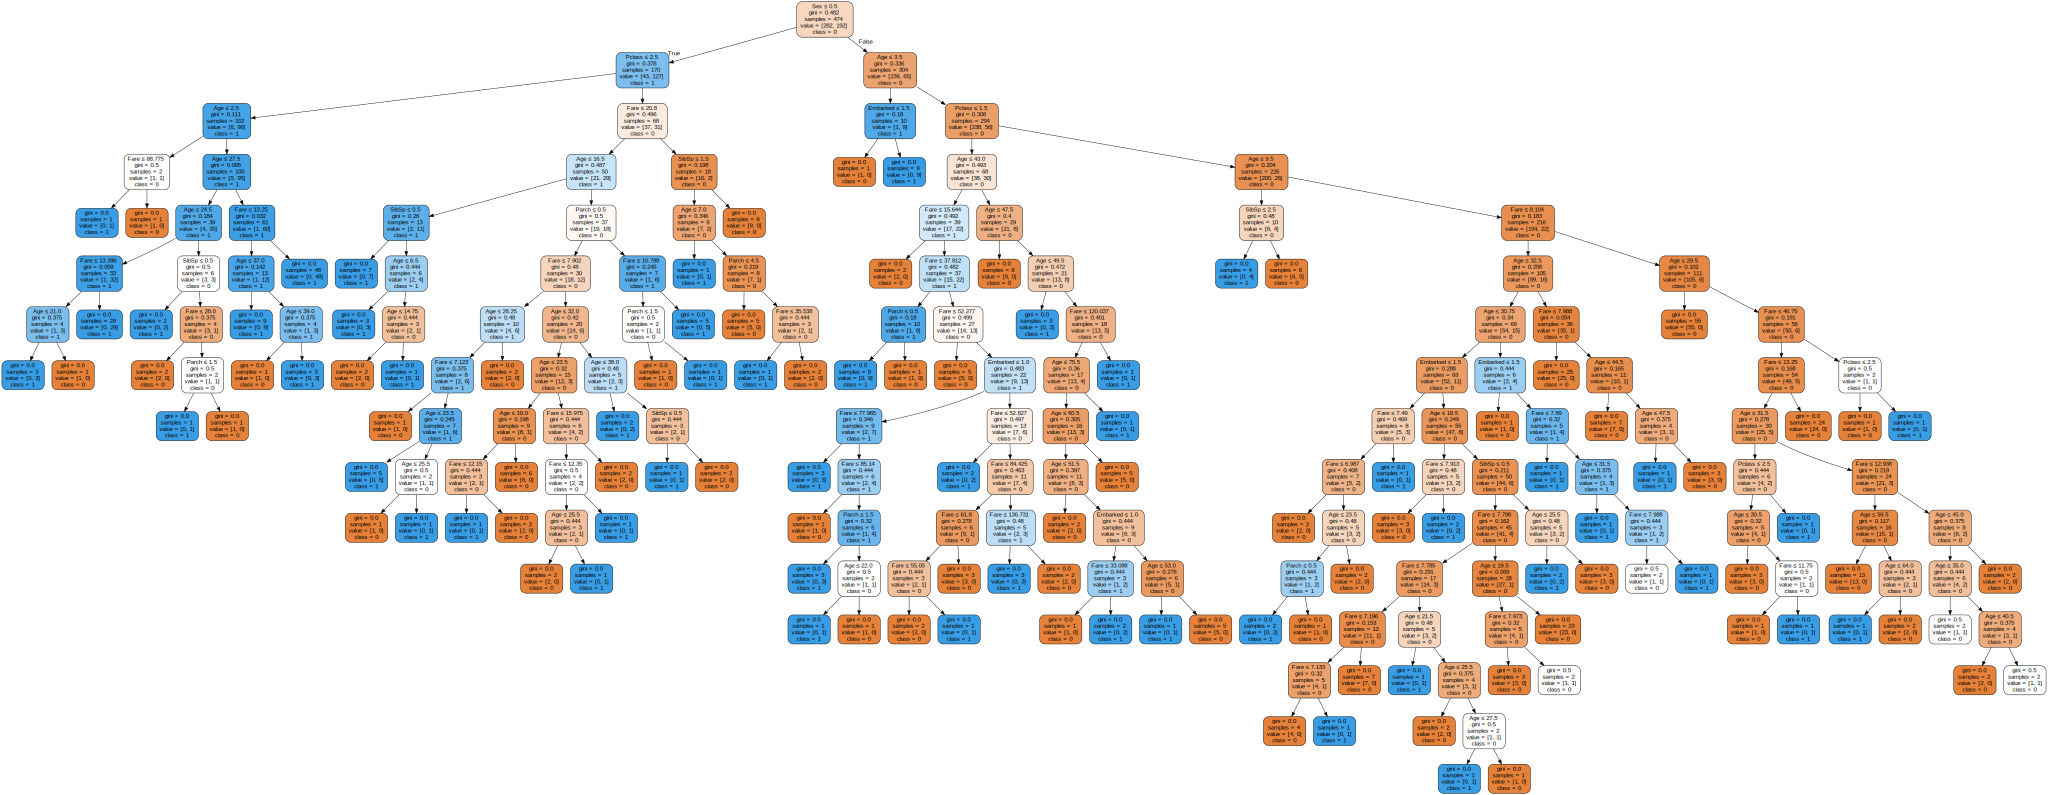

In [9]:
draw_tree(gini_tree, gini_X.columns, ['0','1'], 'titanic_gini')

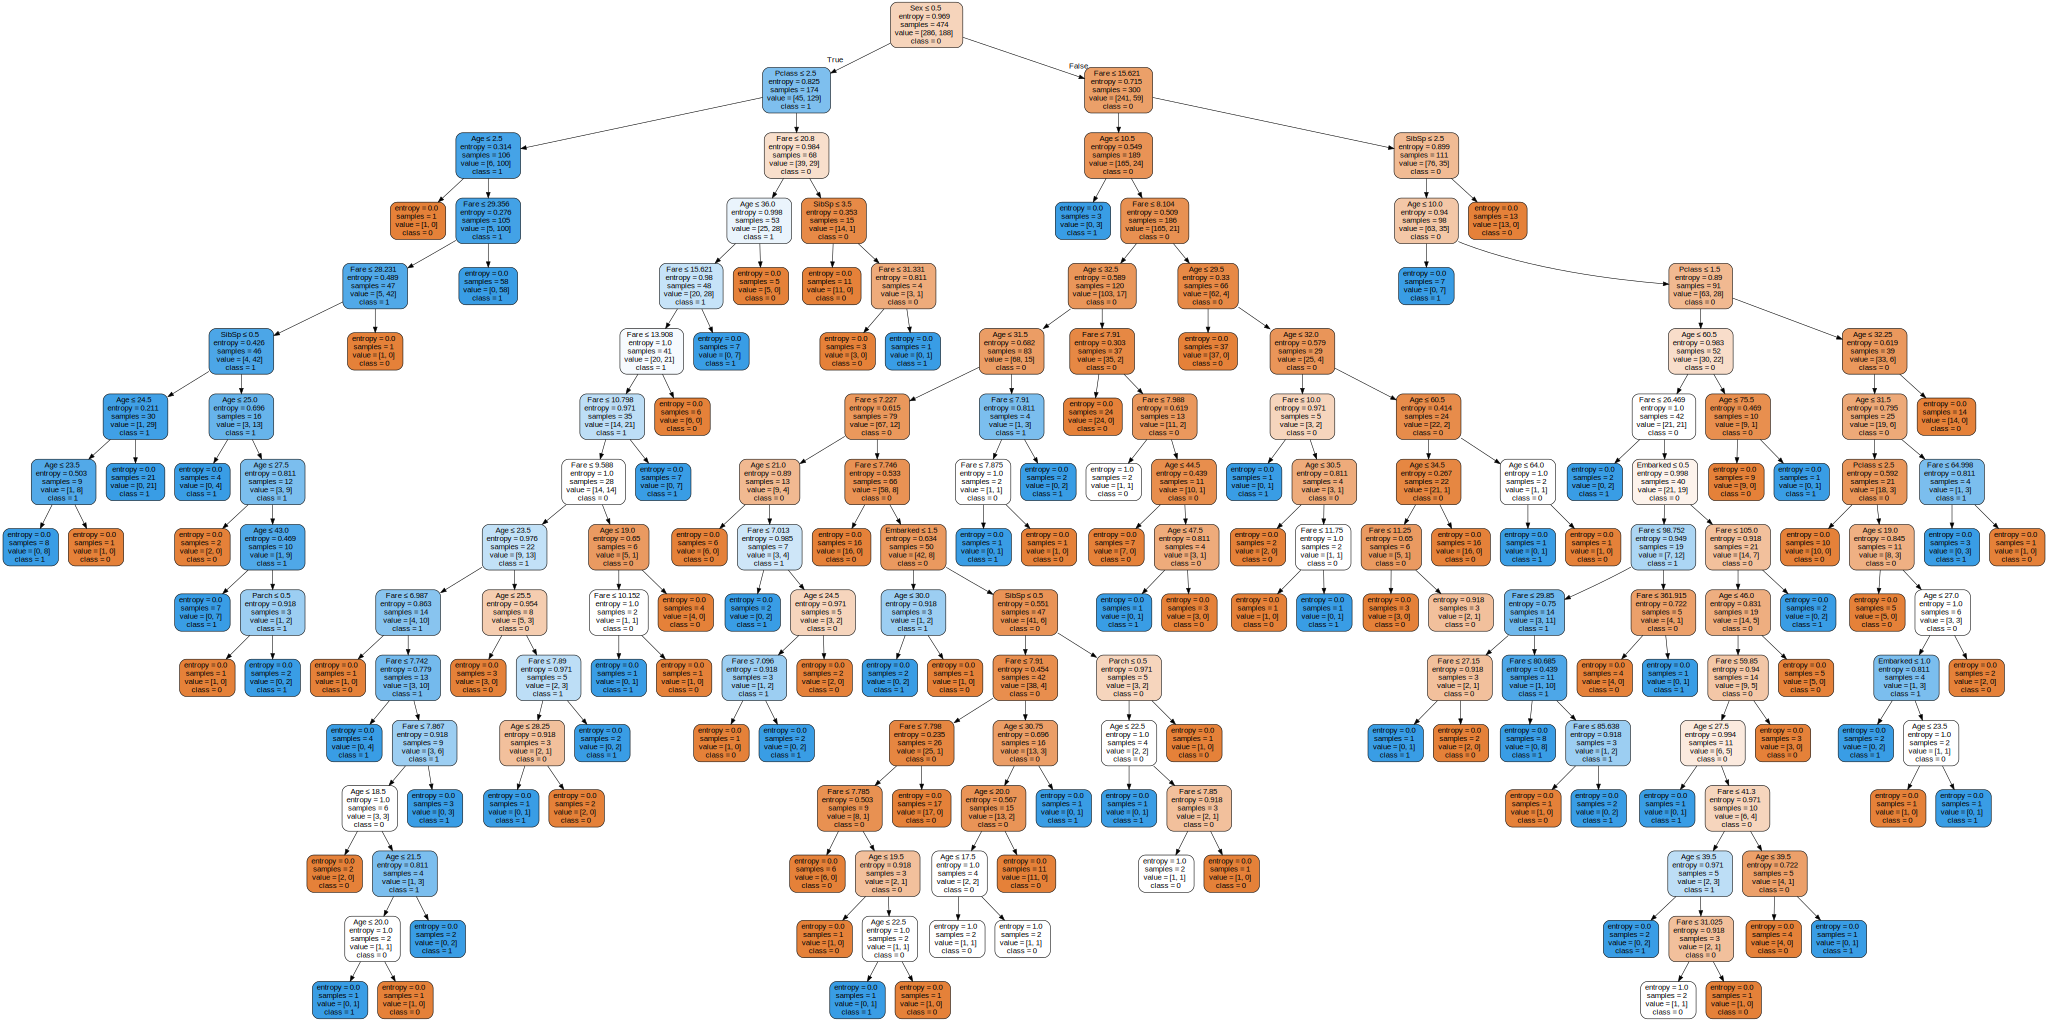

In [12]:
draw_tree(entropy_tree, entropy_X.columns, ['0','1'], 'titanic_entropy')

In [13]:
gini_tree, gini_X = build_Tree(X_train, X_test, criterion='gini', max_depth=5)
entropy_tree, entropy_X = build_Tree(X_train, X_test, criterion='entropy', max_depth=5)

cross_validation(X, criterion='entropy', max_depth=5)
cross_validation(X, criterion='gini', max_depth=5)

Classification using gini on TEST
[[118  31]
 [ 20  69]]
Score: 78.57%


Classification using gini on TRAIN
[[258  34]
 [ 28 154]]
Score: 86.92%


Classification using entropy on TEST
[[126  31]
 [ 12  69]]
Score: 81.93%


Classification using entropy on TRAIN
[[262  49]
 [ 24 139]]
Score: 84.60%


--------------------------------------
Cross validation using entropy
Test: 0 -> score: 80.72289156626506

Test: 1 -> score: 79.72972972972973

Test: 2 -> score: 82.08955223880598

Test: 3 -> score: 81.35593220338984

Test: 4 -> score: 78.2051282051282

Test: 5 -> score: 82.08955223880598

Test: 6 -> score: 79.16666666666666

Test: 7 -> score: 82.85714285714286

Test: 8 -> score: 83.54430379746836

Test: 9 -> score: 69.84126984126983

Final error: 20.03978306553275

--------------------------------------
Cross validation using gini
Test: 0 -> score: 73.23943661971832

Test: 1 -> score: 78.37837837837837

Test: 2 -> score: 78.87323943661971

Test: 3 -> score: 76.19047619047619

Test: 4 -> sco

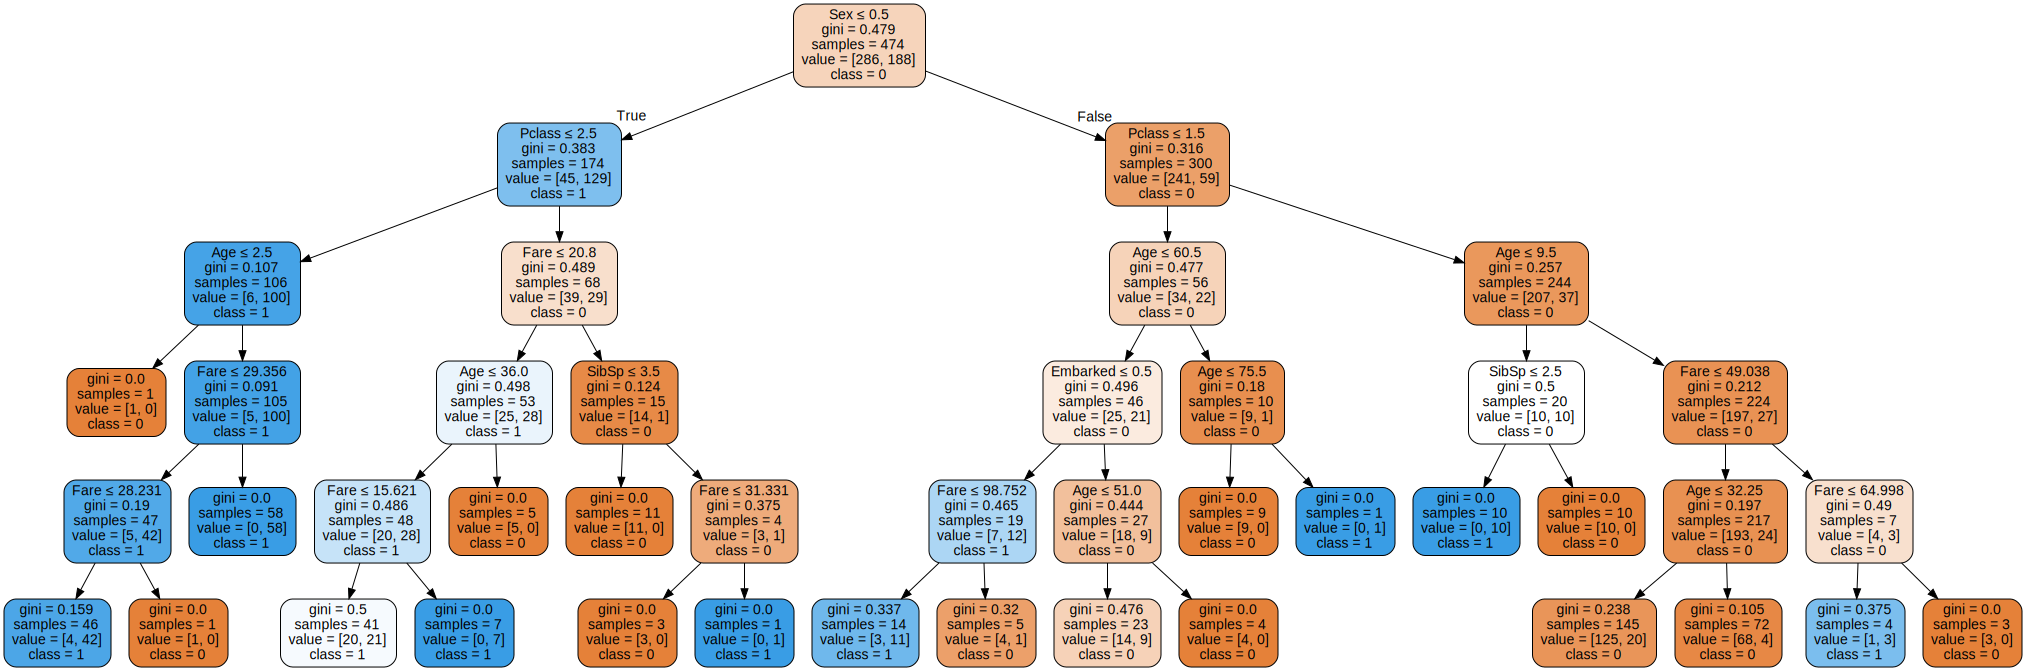

In [14]:
draw_tree(gini_tree, gini_X.columns, ['0','1'], 'titanic_gini_depth')

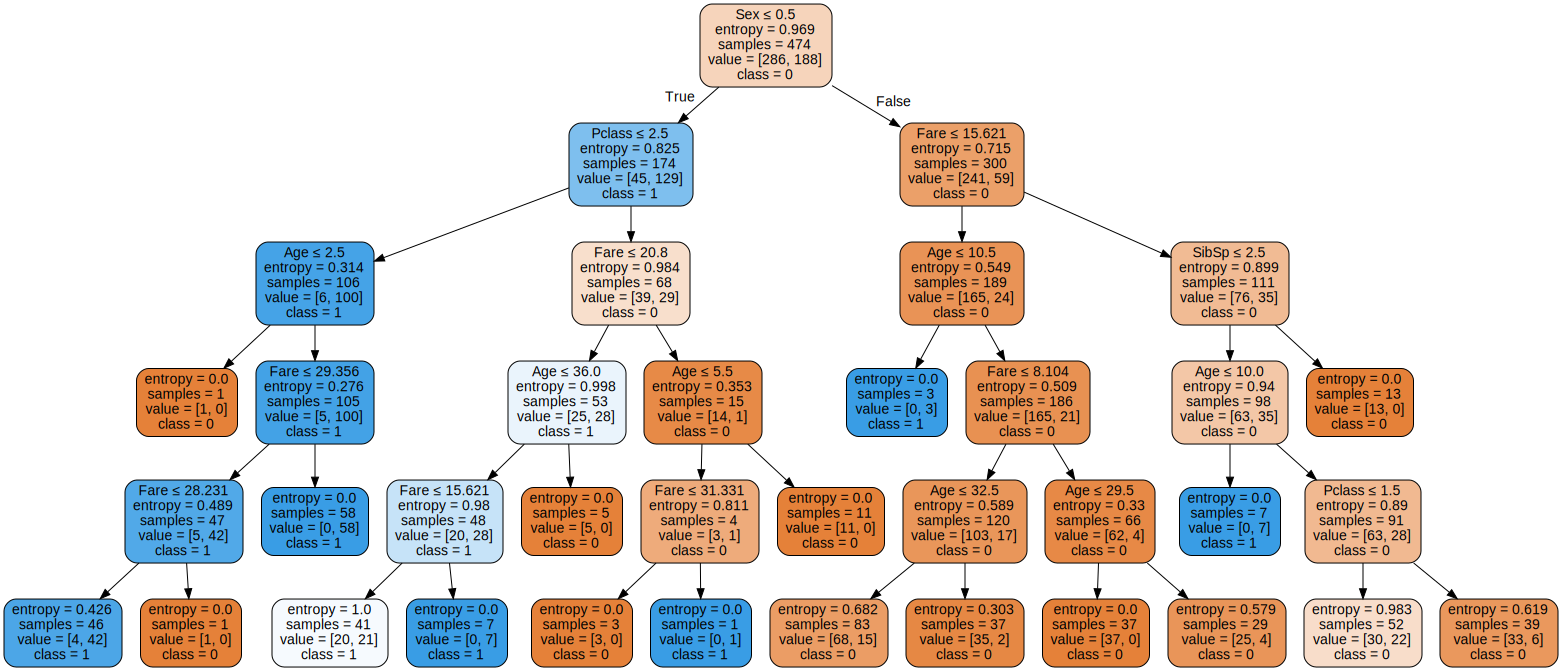

In [15]:
draw_tree(entropy_tree, entropy_X.columns, ['0','1'], 'titanic_entropy_depth')

In [16]:
gini_tree, gini_X = build_Tree(X_train, X_test, criterion='gini', max_depth=5, min_samples_split=10, min_samples_leaf=10)
entropy_tree, entropy_X = build_Tree(X_train, X_test, criterion='entropy', max_depth=5, min_samples_split=10, min_samples_leaf=10)

cross_validation(X, criterion='entropy', max_depth=5, min_samples_split=10, min_samples_leaf=5)
cross_validation(X, criterion='gini', max_depth=5, min_samples_split=10, min_samples_leaf=5)

Classification using gini on TEST
[[112  29]
 [ 26  71]]
Score: 76.89%


Classification using gini on TRAIN
[[252  35]
 [ 34 153]]
Score: 85.44%


Classification using entropy on TEST
[[123  29]
 [ 15  71]]
Score: 81.51%


Classification using entropy on TRAIN
[[255  52]
 [ 31 136]]
Score: 82.49%


--------------------------------------
Cross validation using entropy
Test: 0 -> score: 74.28571428571429

Test: 1 -> score: 78.78787878787878

Test: 2 -> score: 87.14285714285714

Test: 3 -> score: 76.92307692307693

Test: 4 -> score: 84.50704225352112

Test: 5 -> score: 79.45205479452055

Test: 6 -> score: 79.72972972972973

Test: 7 -> score: 76.71232876712328

Test: 8 -> score: 83.33333333333334

Test: 9 -> score: 85.91549295774648

Final error: 19.321049102449837

--------------------------------------
Cross validation using gini
Test: 0 -> score: 83.56164383561644

Test: 1 -> score: 83.5820895522388

Test: 2 -> score: 78.26086956521739

Test: 3 -> score: 77.61194029850746

Test: 4 -> sc

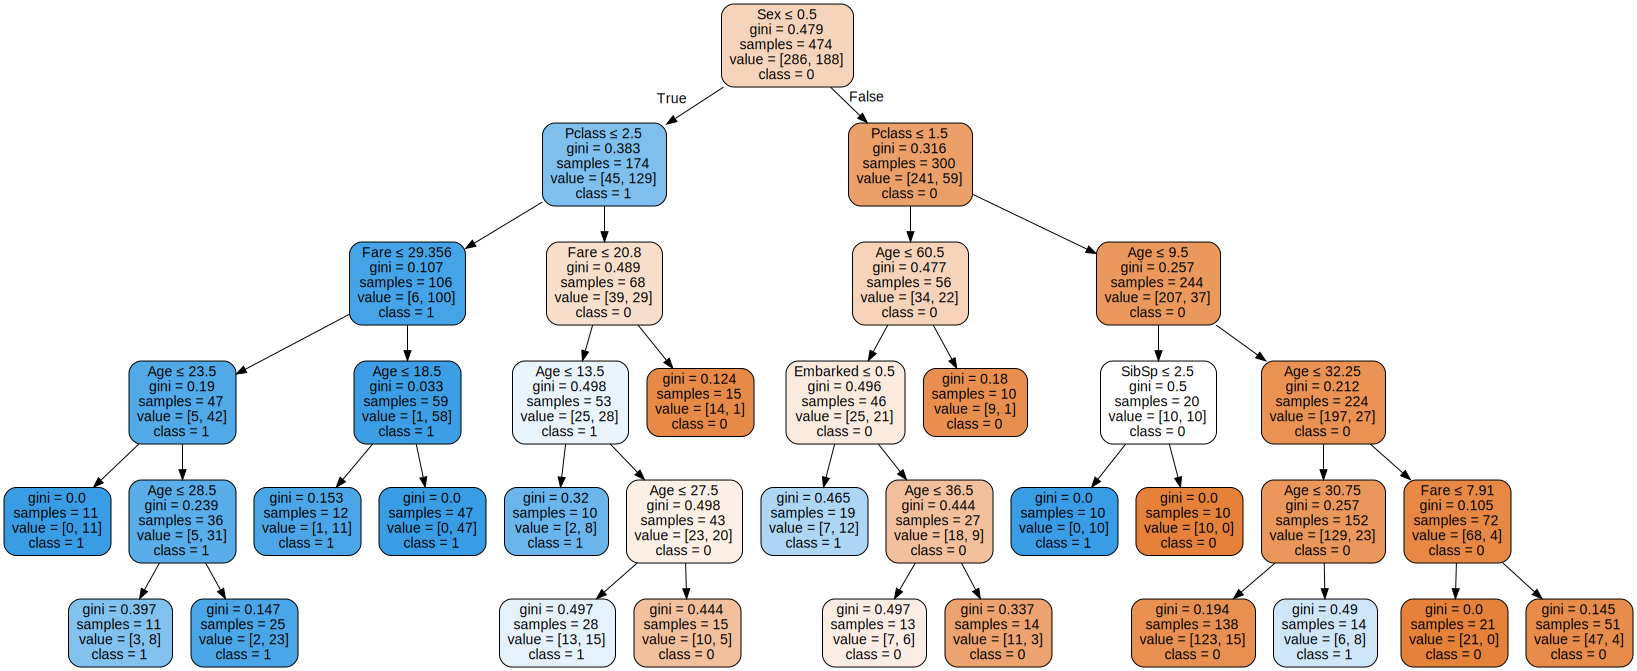

In [17]:
draw_tree(gini_tree, gini_X.columns, ['0','1'], 'titanic_gini_prunned')

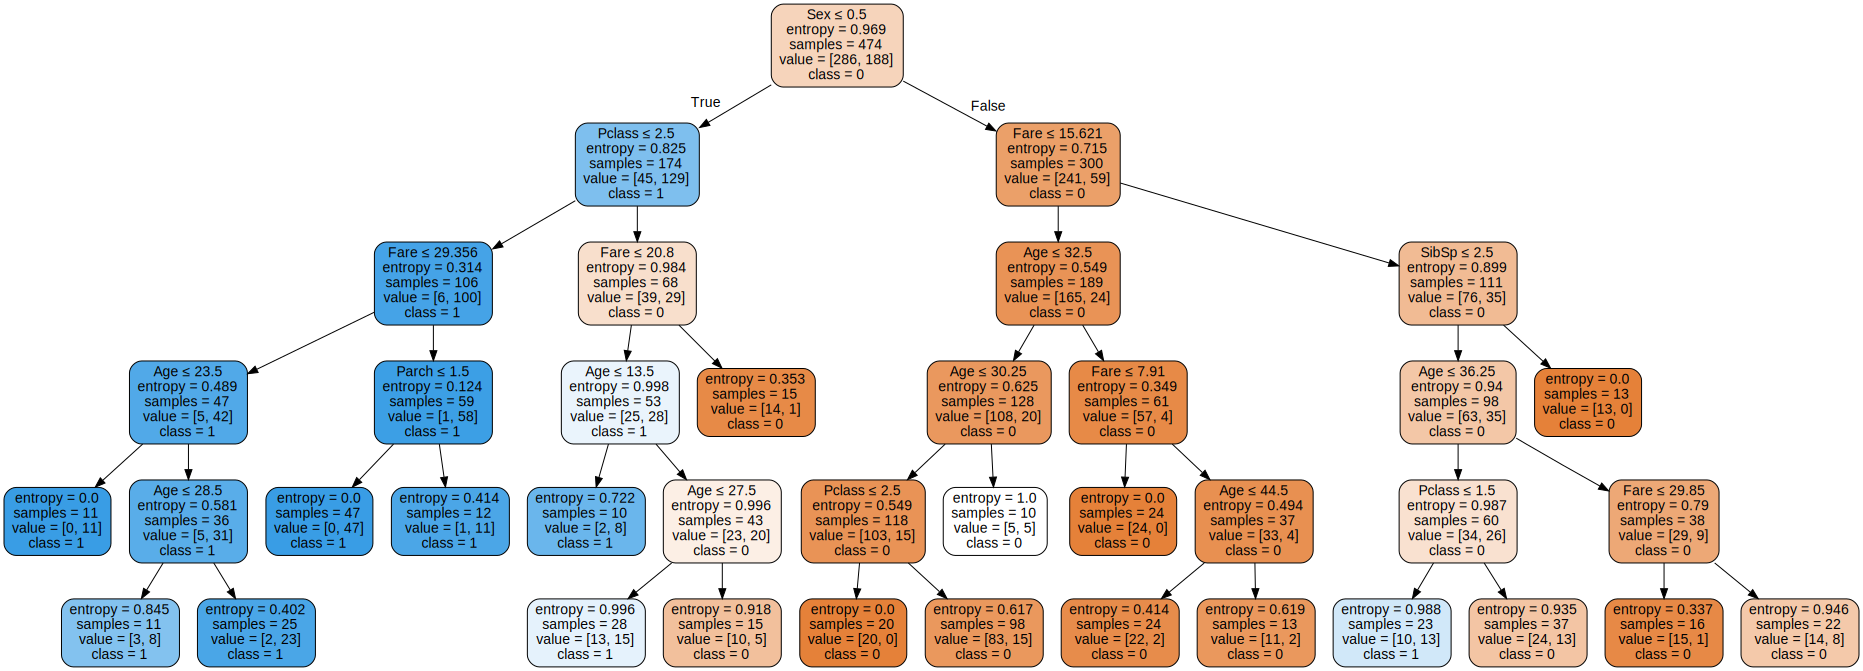

In [19]:
draw_tree(entropy_tree, entropy_X.columns, ['0','1'], 'titanic_entropy_prunned')